In [37]:
import numpy as np
import pygame
import random
import math
from matplotlib import pyplot as plt

BLUE  = (0,0,255)
WHITE = (255,255,255)
BLACK = (0,0,0)
RED   = (255,0,0)

coefficients         = {}
coefficients['eta0'] = 0.5000
coefficients['wght'] = 0.0196
coefficients['eta1'] = 2.9804
coefficients['eta2'] = 0.9157
coefficients['eta3'] = 2.2353
coefficients['eta4'] = 0.5098
params               = {}
params['migration_exists'] = True
params['migration_coeff']  = 0.15
params['number_of_iter']   = 100
params['use_saved_data']   = False

class swarm():
    def __init__(self, func, lowerbounds=[], upperbounds=[], number_of_particles=50, display=False,
                 migrationexists=True):
        self.lowerbounds  = lowerbounds
        self.upperbounds  = upperbounds
        self.nop          = number_of_particles
        self.display      = display
        self.func         = func
        self._vel_max     = 20.0
        self._vel_min     = -20.0
        self.member       = {}
        self.pmig         = 0.15
        
        if self.func.__name__   == 'egg':
            self.lowerbounds  = [-512,-512]
            self.upperbounds  = [512,512]
        elif self.func.__name__ == 'griewank':
            self.lowerbounds  = [-600,-600]
            self.upperbounds  = [600,600]
        
        if self.display:
            self.screen       = pygame.display.set_mode((self.upperbounds[0]-self.lowerbounds[0],
                                                         self.upperbounds[1]-self.lowerbounds[1]))
            pygame.display.set_caption("Particle Swarm Optimization")
            self.screen.fill(WHITE)
                    
        for ii in range(self.nop):
            self.member[str(ii)] = {'center':(0,0)}
            self.member[str(ii)]['best_value'] = 10**5
            
            self.member[str(ii)]['position']      = {str(jj): np.random.random()*\
                                                    (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                     self.lowerbounds[jj] for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['best_position'] = {str(jj): np.random.random()*\
                                                    (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                     self.lowerbounds[jj] for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['velocity']      = {str(jj): np.random.random()\
                                                     for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['center'] = (int(np.round(self.member[str(ii)]['position']['0'])),
                                              int(np.round(self.member[str(ii)]['position']['1'])))
        
        self._evaluate_fitness()
        self._distance()
        
    def _evaluate_fitness(self):
        '''evaluates the fitness function for the members of the swarm'''
        self.fitness_values = {'_'           :{},
                               'sorted'      :{},
                               'best'        :{},
                               'best_sorted' :{}}
        for ii in range(self.nop):
            self.member[str(ii)]['fitness_value'] = self.func([self.member[str(ii)]\
                                                    ['position'][str(jj)] for jj in\
                                                    range(len(self.lowerbounds))])
            
            if self.member[str(ii)]['fitness_value']<self.member[str(ii)]['best_value']:
                self.member[str(ii)]['best_value']            = self.member[str(ii)]['fitness_value']
                for jj in range(len(self.lowerbounds)):
                    self.member[str(ii)]['best_position'][str(jj)] = self.member[str(ii)]['position'][str(jj)]
        
            self.fitness_values['_'][str(ii)]    = self.member[str(ii)]['fitness_value']
            self.fitness_values['best'][str(ii)] = self.member[str(ii)]['best_value']

        self._sorted_fitness_value    = sorted(self.fitness_values['_'].items(), key = lambda kv:(kv[1], kv[0]))
        self.fitness_values['sorted'] = {str(self._sorted_fitness_value[ii][0]):self._sorted_fitness_value[ii][1]\
                                         for ii in range(self.nop)}
        
        self._sorted_best_value       = sorted(self.fitness_values['best'].items(), key = lambda kv:(kv[1], kv[0]))
        self.fitness_values['best_sorted'] = {str(self._sorted_best_value[ii][0]):self._sorted_best_value[ii][1]\
                                              for ii in range(self.nop)}
        
        self.best_position = {list(self.fitness_values['best_sorted'].keys())[ii]:\
                              self.member[list(self.fitness_values['best_sorted'].keys())[ii]]['best_position']\
                              for ii in range(self.nop)}
            
    def _distance(self):
        '''calculates the distances between the members of the swarm'''
        for ii in range(self.nop):
            self.member[str(ii)]['distance'] = {str(jj): {str(kk): self.member[str(ii)]['position'][str(kk)]-\
                                                         self.member[str(jj)]['position'][str(kk)]\
                                                         for kk in range(len(self.lowerbounds))}\
                                                         for jj in range(self.nop)}
            
            self.member[str(ii)]['distance_sorted'] = {str(jj):sorted(np.abs(self.member[str(ii)]['distance']\
                                                      [str(kk)][str(jj)]) for kk in range(self.nop)) for jj in\
                                                       range(len(self.lowerbounds))}
            
            self.member[str(ii)]['abs_distance'] = {str(jj): np.sqrt(math.fsum(self.member[str(ii)]['distance']\
                                                             [str(jj)][str(kk)]**2 for kk in\
                                                             range(len(self.lowerbounds)))) for jj in\
                                                             range(self.nop)}
            
            self.member[str(ii)]['abs_distance_sorted'] = [sorted(self.member[str(ii)]['abs_distance'].items(),\
                                                          key = lambda kv:(kv[1], kv[0]))[jj][1] for jj in\
                                                          range(self.nop)]
            
            self.member[str(ii)]['closest_neighbours'] = [sorted(self.member[str(ii)]['abs_distance'].items(),\
                                                          key = lambda kv:(kv[1], kv[0]))[jj][0] for jj in\
                                                          range(self.nop)]
            
            self.member[str(ii)]['closest_neighbours_fitness_values'] = {self.member[str(ii)]['closest_neighbours'][jj]:\
                                                                         self.member[self.member[str(ii)]['closest_neighbours'][jj]]['fitness_value']\
                                                                         for jj in range(self.nop)}
            
            self.member[str(ii)]['closest_neigbours_best'] = sorted(list(self.member[str(ii)]\
                                                                 ['closest_neighbours_fitness_values'].items())[1:5],
                                                                 key=lambda kv:(kv[1],kv[0]))[0][0]
            
            '''distance from the closest particle which has the best fitness value'''
            self.member[str(ii)]['distance_from_closest_best'] = self.member[str(ii)]['distance']\
                                                                [self.member[str(ii)]['closest_neigbours_best']]
    def _migration(self):
        '''migration calculations are generated if there exists migration'''
        if np.random.random() < 1.0:
            self.nowp = int(np.round(0.20*self.nop))        # number of worst particles
            self.nobp = int(np.round(0.20*self.nop))        # number of best particles
            self.w2bp = self._sorted_fitness_value[::-1]    # sorted worst to best particles and fitnesses
            self.b2wp = self._sorted_fitness_value          # sorted best to worst particles and fitnesses
            self.bafv = np.average([self._sorted_fitness_value[ii][1]\
                                    for ii in range(self.nobp)]) # best average fitness value
            self.worst_particle_indices = {}
            counter = 0
            for ii in range(4):
                # worst particle indices are seperated 4 sub-groups from worst to best
                self.worst_particle_indices[ii] = [self.w2bp[counter+ii][0] for\
                                                   ii in range(int(np.round(0.25*self.nowp)))]
                counter = counter + int(np.round(0.25*self.nowp))
                for ind in (self.worst_particle_indices[ii]):
                    self.member[str(ind)]['position'] = {str(jj): np.random.random()*\
                                                                  (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                                  self.lowerbounds[jj] for jj in\
                                                                  range(len(self.lowerbounds))}
                    self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                                  for jj in range(len(self.lowerbounds))}
                
            sign = np.random.permutation([-1,1])[0] 
        
    def _optimize(self):
        '''PSO algoritm'''
        for ii in range(self.nop):
            for jj in range(len(self.lowerbounds)):
                self.member[str(ii)]['velocity'][str(jj)] =  coefficients['eta0'] * np.random.random()*\
                                                             ((coefficients['wght'] * \
                                                             self.member[str(ii)]['velocity'][str(jj)]) + \
                                                             coefficients['eta1'] * np.random.random() * \
                                                             self.member[str(ii)]['best_position'][str(jj)] - \
                                                             self.member[str(ii)]['position'][str(jj)] + \
                                                             coefficients['eta2'] * np.random.random() * \
                                                             list(self.best_position.values())[0][str(jj)] - \
                                                             self.member[str(ii)]['position'][str(jj)] + \
                                                             coefficients['eta3'] * np.random.random() * \
                                                             list(self.member[str(ii)]['distance_sorted'].values())[jj][1] + \
                                                             coefficients['eta4'] * np.random.random() * \
                                                             self.member[str(ii)]['distance_from_closest_best']\
                                                             [str(jj)])
        
                if self.member[str(ii)]['velocity'][str(jj)] > self._vel_max:
                    self.member[str(ii)]['velocity'][str(jj)] = self._vel_max
                elif self.member[str(ii)]['velocity'][str(jj)] < self._vel_min:
                    self.member[str(ii)]['velocity'][str(jj)] = self._vel_min
                    
                self.member[str(ii)]['position'][str(jj)] = self.member[str(ii)]['position'][str(jj)] + \
                                                            self.member[str(ii)]['velocity'][str(jj)]
                
                if self.member[str(ii)]['position'][str(jj)] > self.upperbounds[jj]:
                    self.member[str(ii)]['position'][str(jj)] = self.upperbounds[jj]
                elif self.member[str(ii)]['position'][str(jj)] < self.lowerbounds[jj]:
                    self.member[str(ii)]['position'][str(jj)] = self.lowerbounds[jj]

                    
    def update(self): 
        '''updates the position and velocity of the members of the swarm'''
        self._optimize()
        self._evaluate_fitness()
        self._distance()
        self._migration()
        self._distance()
        
        for ii in range(self.nop):
            self.member[str(ii)]['center'] = (int(np.round(self.member[str(ii)]['position']['0'])\
                                                  -self.lowerbounds[0]),
                                              int(np.round(self.member[str(ii)]['position']['1'])\
                                                  +self.upperbounds[0]))
            if self.display:
                pygame.draw.circle(self.screen,BLUE,self.member[str(ii)]['center'],2)

        if self.display:
            pygame.display.flip()     
            self.screen.fill(WHITE)

In [126]:
list_sign = {'-1':0,
             '+1':0}
for ii in range(10000):
    if np.random.permutation([-1,1])[0] == 1:
        list_sign['+1'] = list_sign['+1'] + 1
    else:
        list_sign['-1'] = list_sign['-1'] + 1

In [127]:
list_sign

{'-1': 5028, '+1': 4972}

In [121]:
particles._migration()
particles._evaluate_fitness()

In [97]:
particles.nobp

10

In [98]:
particles.nowp

10

In [99]:
particles.w2bp[0:10]

[('17', 152.8642496674258),
 ('8', 65.79779011844832),
 ('13', 63.57333015636081),
 ('39', 57.85214591172739),
 ('45', 41.80581233548645),
 ('49', 35.173875446635954),
 ('11', 33.730470811214644),
 ('33', 31.38507021797595),
 ('30', 24.11945125551685),
 ('14', 22.51595591364412)]

In [79]:
[particles.w2bp[ii][0] for ii in range(5)] 

['18', '23', '16', '47', '31']

In [80]:
particles.bafv

-265.56120047961247

In [81]:
particles.worst_particle_indices

{0: ['18', '23'], 1: ['16', '47'], 2: ['31', '48'], 3: ['12', '44']}

In [82]:
particles.member['18']['position']

{'0': 438.7939593133501, '1': -147.43057467271785}

In [83]:
for ind in (particles.worst_particle_indices[0]):
    print(particles.member[str(ind)]['position'])

{'0': 438.7939593133501, '1': -147.43057467271785}
{'0': -342.8381713094592, '1': 323.20494049559886}


In [47]:
particles._sorted_fitness_value

[('42', -620.0716689680245),
 ('33', -526.049814117753),
 ('48', -504.25498208369606),
 ('2', -464.9074790389976),
 ('45', -431.65147036804154),
 ('4', -412.3502300793992),
 ('12', -405.3633163173083),
 ('14', -401.86798026078895),
 ('24', -400.1053243676698),
 ('46', -398.2160631039642),
 ('21', -359.29943571667366),
 ('30', -353.7290660710305),
 ('35', -336.39797337853827),
 ('28', -326.51610199024185),
 ('39', -307.0669826388125),
 ('44', -292.6213450327459),
 ('31', -281.04711041079014),
 ('38', -263.2274832018726),
 ('23', -216.08846170611582),
 ('10', -203.38200536016092),
 ('34', -201.37904330496949),
 ('11', -199.1379826573878),
 ('36', -191.62654210342825),
 ('37', -188.00886359739067),
 ('26', -181.8770019415204),
 ('13', -164.754021385729),
 ('41', -141.43534506642558),
 ('18', -129.41632995098968),
 ('27', -121.66136783656881),
 ('9', -103.42743047893207),
 ('3', -59.68698151471363),
 ('22', -52.32537763034564),
 ('8', -51.47426480421029),
 ('15', -49.975618903704046),
 ('0

In [48]:
def egg(*args):
    x1    = args[0][0]
    x2    = args[0][1]
    term1 = -(x2+47) * math.sin(math.sqrt(math.fabs(x2+x1/2+47)))
    term2 = -x1 * math.sin(math.sqrt(math.fabs(x1-(x2+47))))
    out   = term1 + term2
    return out

def griewank(*args):
    d    = len(args[0])
    sum  = 0
    prod = 1
    for ii in range(d):
        xi   = args[0][ii]
        sum  = sum + xi**2/4000
        prod = prod * math.cos(xi/math.sqrt(ii+1))
    out = sum - prod + 1
    return out

def bukin6(*args):
    x1 = args[0][0]
    x2 = args[0][1]    
    term1 = 100 * math.sqrt((abs(x2-0.01*x1**2)))
    term2 = 0.01 * abs(x1+10)    
    out = term1 + term2
    return out

def ackley(*args):
    d    = len(args[0])
    c    = math.pi * 2
    b    = 0.20
    a    = 20
    
    sum1 = 0
    sum2 = 0
    
    for ii in range(d):
        xi   = args[0][ii]
        sum1 = sum1 + xi**2
        sum2 = sum2 + math.cos(c*xi)
    
    term1 = -a * math.exp(-b*math.sqrt(sum1/d))
    term2 = -math.exp(sum2/d)
    
    y = term1 + term2 + a + math.exp(1)
    
    return 

def drop(*args):
    x1 = args[0][0]
    x2 = args[0][1]
    frac1 = 1+math.cos(12*math.sqrt(x1**2 + x2**2))
    frac2 = 0.5*(x1**2 + x2**2) + 2
    out = -frac1/frac2
    return out

In [49]:
fitness_function             = {}
fitness_function['egg']      = egg
fitness_function['griewank'] = griewank
fitness_function['bukin6']   = bukin6
fitness_function['ackley']   = ackley
fitness_function['drop']     = drop

In [50]:
particles = swarm(func=fitness_function['egg'], number_of_particles=50,display=True)

In [51]:
particles.screen

<Surface(1024x1024x32 SW)>

In [52]:
for ii in range(20):
    particles.update()
    print('iteration no  : ',ii+1)
    print('best_particle : ',list(particles.best_position.keys())[0])
    print('fitness_value : ',particles.member[list(particles.best_position.keys())[0]]['fitness_value'])
    print('best_value    : ',particles.member[list(particles.best_position.keys())[0]]['best_value'])
    print('position      : ',particles.member[list(particles.best_position.keys())[0]]['position'])
    print('best_position : ',particles.member[list(particles.best_position.keys())[0]]['best_position'])
    print('--------------------------------------------------------')

iteration no  :  1
best_particle :  16
fitness_value :  -741.8079037458937
best_value    :  -756.5296817166939
position      :  {'0': -440.2634481885724, '1': -372.43085033868897}
best_position :  {'0': -460.2634481885724, '1': -392.43085033868897}
--------------------------------------------------------
iteration no  :  2
best_particle :  16
fitness_value :  -756.5296817166939
best_value    :  -756.5296817166939
position      :  {'0': -460.2634481885724, '1': -392.43085033868897}
best_position :  {'0': -460.2634481885724, '1': -392.43085033868897}
--------------------------------------------------------
iteration no  :  3
best_particle :  16
fitness_value :  -740.3761806863494
best_value    :  -756.5296817166939
position      :  {'0': -464.12763271870716, '1': -396.6909293604436}
best_position :  {'0': -460.2634481885724, '1': -392.43085033868897}
--------------------------------------------------------
iteration no  :  4
best_particle :  27
fitness_value :  -760.1123293563619
best_va

In [53]:
particles.best_position

{'27': {'0': -465.74381780546287, '1': -384.32060122009216},
 '16': {'0': -460.2634481885724, '1': -392.43085033868897},
 '15': {'0': 461.3016584350918, '1': -298.17479525454826},
 '23': {'0': 294.89173037356807, '1': -494.6378630357208},
 '14': {'0': -283.4138787021726, '1': -456.7655346926073},
 '43': {'0': -477.4480969788806, '1': -388.68743957258994},
 '31': {'0': -297.69059516011987, '1': -453.54139399635574},
 '24': {'0': -311.8560642539753, '1': -472.0},
 '13': {'0': 376.54468578444545, '1': -364.55480816957225},
 '37': {'0': -165.0685604043846, '1': -504.2859526960059},
 '22': {'0': 413.8330862707586, '1': 154.20387135929786},
 '41': {'0': -99.61482352637506, '1': 419.35413304479266},
 '30': {'0': -101.55914614467504, '1': 415.1159744542173},
 '29': {'0': 397.75812535139, '1': 145.9957360421916},
 '47': {'0': 300.8138241606357, '1': 460.58489159457804},
 '32': {'0': 362.42612733041415, '1': -352.3796151349643},
 '5': {'0': -125.12905302591895, '1': 420.056834276549},
 '17': {'0

In [54]:
particles.fitness_values['best_sorted']

{'27': -760.1123293563619,
 '16': -756.5296817166939,
 '15': -708.2963043245818,
 '23': -699.17602410121,
 '14': -683.4507206802762,
 '43': -673.1771034582204,
 '31': -658.3740618428628,
 '24': -656.4280632636387,
 '13': -648.2274508327598,
 '37': -595.19045999399,
 '22': -570.0195313386989,
 '41': -563.3598434475352,
 '30': -557.5840340815868,
 '29': -548.4309621733153,
 '47': -543.6178280959824,
 '32': -538.0874572902649,
 '5': -534.6035586909554,
 '17': -522.042505176325,
 '11': -520.0402607945903,
 '6': -516.8453087217538,
 '25': -504.08045043442405,
 '38': -502.97785813343,
 '0': -485.0443216785073,
 '45': -478.7040644222783,
 '1': -473.36660706491614,
 '46': -472.4753957236304,
 '48': -455.0680636114881,
 '44': -438.4519694655432,
 '12': -436.74947995407746,
 '39': -427.76546392958056,
 '35': -416.67363729664316,
 '26': -412.7199848819676,
 '9': -410.3398534079528,
 '34': -382.838213431578,
 '21': -369.95551725613666,
 '10': -362.8588158321431,
 '7': -355.49601790265996,
 '20': -

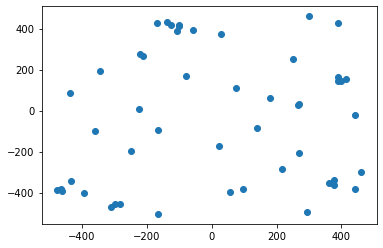

In [55]:
plt.scatter([list(particles.best_position.values())[ii]['0'] for ii in range(particles.nop)],
            [list(particles.best_position.values())[ii]['1'] for ii in range(particles.nop)])

In [ ]:
fitness_function['griewank']([particles.member[list(particles.best_position.keys())[0]]['position'][str(jj)] for jj in range(len(particles.lowerbounds))])

In [ ]:
particles.func([particles.member[list(particles.best_position.keys())[0]]['position'][str(jj)] for jj in range(len(particles.lowerbounds))])

In [ ]:
[particles.member[list(particles.best_position.keys())[0]]['position'][str(jj)] for jj in range(len(particles.lowerbounds))]

In [ ]:
particles.member[list(particles.best_position.keys())[0]]['fitness_value']

In [ ]:
particles.fitness_values['_'][list(particles.best_position.keys())[0]]

In [ ]:
particles.fitness_values['best'][list(particles.best_position.keys())[0]]

In [ ]:
particles.member[list(particles.best_position.keys())[0]]

In [ ]:
# Particle Swarm Optimization (PSO) Code%% Girdiler
minimization = 1             # 0: maximization, 1: minimization
coeff        = 1.0           # katsayı // 1.0
w            = 0.0196        # weight of the partical velocity  //w    = 0.0196;
eta1         = 3.9804        # eta1 = 3.9804 // partical best
eta2         = 0.2157        # eta2 = 0.2157   // global best
eta3         = 3.2353        # eta3 = 3.2353  // closest neighbour
eta4         = 0.5098        # eta4 = 0.5098 // closest best neighbour
eta5         = 0.00          # eta5 = 0.00 // average position of the swarm
eta6         = 0.00          # eta6 = 0.00 // average velocity of the swarm
#fitness_function = @egg;    # the function that will be optimized
number_of_particles = 150    # The number of the elements (particles/bees/ants/birds) inside the swarm
number_of_variables = 2      # variable sayısı / dimension sayısı
migration           = 1      # 0: no-migration, 1: migration
pmig                = 0.15   # migration probability if migration is allowed // 0.15
mig_katsayi         = 0.0110 # migration katsayısı // = pmig (0.15)
objective_number    = 1      # the number of the objectives that the fitness function gives out
iteration           = 200    # Number of iterations
saved_data          = 1      # 1: use saved x_encoded values, 0: start randomly

In [ ]:
lower_boundaries = zeros(1,number_of_variables);
upper_boundaries = zeros(1,number_of_variables);

lower_boundaries(1,:) = [-512 -512];
upper_boundaries(1,:) = [512 512];
% lower_boundaries(1,:) = 0 * ones(1,number_of_variables);
% upper_boundaries(1,:) = 100 * ones(1,number_of_variables);
vel_min = -20;
vel_max = 20;

position = zeros(number_of_particles,number_of_variables);
velocity = zeros(number_of_particles,number_of_variables);
[row col] = size(position);          %%% size of the domain row: number of particles, col: number of variables
globalbest_value(1,1:col) = 1000000;

distances = zeros(number_of_particles,number_of_particles);
distances(1:number_of_particles,1:number_of_particles*number_of_variables) = 0;
closest_distances(1:number_of_particles,1:4*number_of_variables) = 1000000000;     %%% Her bir particle'�n kendisi dahil en yak�n 4 tane kom�usu i�in mesafeler bulunuyor.
closest_particles(1:number_of_particles,1:4*number_of_variables) = 0;

%%%% Kaydedilmi� veri kullan�lmadan, rastgele bir ver iseti ile ba�lan�yor %%%%

if(saved_data == 0)
    %%
    %%% Her bir partical i�in rastgele pozisyon (x1, x2, ..., xn)  ve h�z
    %%% atamas� yap�l�yor.
    for i = 1:row
        for j = 1:col
            position(i,j) = (upper_boundaries(1,j) - lower_boundaries(1,j)) * random('unif',0,1) + lower_boundaries(1,j);
            velocity(i,j) = random('unif',0,1);
        end
        fitness_values(i,:) = fitness_function(position(i,:));
    end
    personal_best_pos = position;
    
    total_velocity   = zeros(1,col);
    total_position   = zeros(1,col);
    average_velocity = zeros(1,col);
    average_position = zeros(1,col);
    for j = 1:col
        for i = 1:row
            total_velocity(1,j) = total_velocity(1,j) + velocity(i,j);
            total_position(1,j) = total_position(1,j) + position(i,j);
        end
        average_velocity(1,j) = total_velocity(1,j) / row;
        average_position(1,j) = total_position(1,j) / row;
    end
    
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%
    %%% Her bir partical'�n di�er partical'la ile aras�ndaki mesafe her bir variable i�in ayr� ayr� bulunuyor %%%
    for j = 1:col
        for i = 1:row
            for k = 1:row
                column = (j-1)*row + k;
                distances(i,column) = abs(position(i,j) - position(k,j));
            end
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%
    %%% Her bir particle'�n kendisi dahil en yak�n 4 tane kom�usu i�in
    %%% mesafeler ve partical indisleri bulunuyor. %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    for j = 1:col
        for i=1:row
            column = (j-1)*row ;
            sorted_neighbours(i,column+1:column+row) = sort(distances(i,column+1:column+row));
        end
    end
    
    for j = 1:col
        for i=1:row
            column = (j-1)*row ;
            sutun = (j-1) * 4;
            closest_distances(i,sutun+1:sutun+4) = sorted_neighbours(i,column+1:column+4);
        end
    end
    for j = 1:col
        for i=1:row
            for k=1:4
                column = (j-1)*row;
                sutun = (j-1) * 4 + k;
                closest_particles(i,sutun) = find(closest_distances(i,sutun) == distances(i,column+1:column+row),1,'first');
            end
        end
    end
    
    %%
    %%% Her bir partical i�in, o zaman kadar elde edilmi� en iyi fitness
    %%% de�eri kaydediliyor.
    for ii=1:row
        partical_best(ii,:) = fitness_function(position(ii,:));
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%%%%% En yak�n 4 particle'�n fitness de�erleri yaz�l�yor %%%%%%%%%%%%%
    for j = 1:col
        for i=1:row
            for k=1:4
                sutun = (j-1) * 4 + k;
                closest_particles_fitness_values(i,sutun) = fitness_values(closest_particles(i,sutun),1);
            end
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%%%% En yak�n 4 partical'�n fitness de�erleri ve particle'lar�n indisleri her bir variable i�in
    %%%%% en alttan en yukar�ya do�ru s�ralan�yor
    
    %%% En yak�n particle'lar�n fitness de�erleri s�ralan�yor
    closest_particles_fitness_values_sorted(:,:) = closest_particles_fitness_values(:,:);
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            sorted_fitness_values(i,sutun+2:sutun+4) = sort(closest_particles_fitness_values(i,sutun+2:sutun+4));
        end
    end
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            closest_particles_fitness_values_sorted(i,sutun+2:sutun+4) = sorted_fitness_values(i,sutun+2:sutun+4);
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%% En yak�n particle'lar�n indisleri s�ralan�yor
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            closest_best_particles_indices(i,j) = closest_particles(i,find(closest_particles_fitness_values_sorted(i,sutun+2)==closest_particles_fitness_values(i,sutun+1:sutun+4),1,'first')+sutun);
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%
    %%%%% Global en iyi fitness de�eri bulunuyor
    if(minimization == 1)
        for ii=1:row
            if (partical_best(ii,:) < globalbest_value)
                globalbest_value = partical_best(ii,:);
                global_best_index = ii;
                global_best_position = position(global_best_index,:);
            end
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    genn = 1;
    %%
    %%% kaydedilmi� veri kullan�l�yor
else
    load('PSO_saved_data.mat');
    [saved_data_birey_sayisi saved_data_col] = size(fitness_values);
    genn = genn_saved;
    if(row>saved_data_birey_sayisi)
        for i = saved_data_birey_sayisi+1:row
            for j = 1:col
                position(i,j) = (upper_boundaries(1,j) - lower_boundaries(1,j)) * random('unif',0,1) + lower_boundaries(1,j);
                velocity(i,j) = random('unif',0,1);
            end
            fitness_values(i,:) = fitness_function(position(i,:));
            personal_best_pos(i,:) = position(i,:);
        end
        %%
        %%% Her bir partical'�n di�er partical'la ile aras�ndaki mesafe her bir variable i�in ayr� ayr� bulunuyor %%%
        for j = 1:col
            for i = 1:row
                for k = 1:row
                    column = (j-1)*row + k;
                    distances(i,column) = abs(position(i,j) - position(k,j));
                end
            end
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        %%
        %%% Her bir particle'�n kendisi dahil en yak�n 4 tane kom�usu i�in
        %%% mesafeler ve partical indisleri bulunuyor. %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        for j = 1:col
            for i=1:row
                column = (j-1)*row ;
                sorted_neighbours(i,column+1:column+row) = sort(distances(i,column+1:column+row));
            end
        end
        
        for j = 1:col
            for i=1:row
                column = (j-1)*row ;
                sutun = (j-1) * 4;
                closest_distances(i,sutun+1:sutun+4) = sorted_neighbours(i,column+1:column+4);
            end
        end
        for j = 1:col
            for i=1:row
                for k=1:4
                    column = (j-1)*row;
                    sutun = (j-1) * 4 + k;
                    closest_particles(i,sutun) = find(closest_distances(i,sutun) == distances(i,column+1:column+row),1,'first');
                end
            end
        end
        
        %%
        %%% Her bir partical i�in, o zaman kadar elde edilmi� en iyi fitness
        %%% de�eri kaydediliyor.
        for ii=saved_data_birey_sayisi+1:row
            partical_best(ii,:) = fitness_function(position(ii,:));
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        %%%%%% En yak�n 4 particle'�n fitness de�erleri yaz�l�yor %%%%%%%%%%%%%
        for j = 1:col
            for i=1:row
                for k=1:4
                    sutun = (j-1) * 4 + k;
                    closest_particles_fitness_values(i,sutun) = fitness_values(closest_particles(i,sutun),1);
                end
            end
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        %%%%% En yak�n 4 partical'�n fitness de�erleri ve particle'lar�n indisleri her bir variable i�in
        %%%%% en alttan en yukar�ya do�ru s�ralan�yor
        
        %%% En yak�n particle'lar�n fitness de�erleri s�ralan�yor
        closest_particles_fitness_values_sorted(:,:) = closest_particles_fitness_values(:,:);
        for j = 1:col
            for i=1:row
                sutun = (j-1) * 4 ;
                sorted_fitness_values(i,sutun+2:sutun+4) = sort(closest_particles_fitness_values(i,sutun+2:sutun+4));
            end
        end
        for j = 1:col
            for i=1:row
                sutun = (j-1) * 4 ;
                closest_particles_fitness_values_sorted(i,sutun+2:sutun+4) = sorted_fitness_values(i,sutun+2:sutun+4);
            end
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        %%% En yak�n particle'lar�n indisleri s�ralan�yor
        for j = 1:col
            for i=1:row
                sutun = (j-1) * 4 ;
                closest_best_particles_indices(i,j) = closest_particles(i,find(closest_particles_fitness_values_sorted(i,sutun+2)==closest_particles_fitness_values(i,sutun+1:sutun+4),1,'first')+sutun);
            end
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
        %%
        %%%%% Global en iyi fitness de�eri bulunuyor
        if(minimization == 1)
            for ii=1:row
                if (partical_best(ii,:) < globalbest_value)
                    globalbest_value = partical_best(ii,:);
                    global_best_index = ii;
                    global_best_position = position(global_best_index,:);
                end
            end
        end
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    end
end

scatterplot(position(:,1:2));

iter = 0;

%%
%%%%%%% iterasyonlar ba�l�yor
while(iter < iteration)
    remainder = rem(iter,10);
    %%
    %%% Pozisyon ve h�z de�erleri g�ncelleniyor.
    for ii=1:row
        
        for jj=1:col
            velocity(ii,jj) = coeff * (w * velocity(ii,jj) ...
                + eta1 * random('unif',0,1) * (personal_best_pos(ii,jj) - position(ii,jj))...
                + eta2 * random('unif',0,1) * (global_best_position(:,jj) - position(ii,jj)))...
                + eta3 * random('unif',0,1) * (position(closest_particles(ii,(jj-1)*4+2),jj) - position(ii,jj))...
                + eta4 * random('unif',0,1) * (position(closest_best_particles_indices(ii,jj) ,jj) - position(ii,jj))...
                + eta5 * random('unif',0,1) * (average_position(1,jj) - position(ii,jj))...
                + eta6 * random('unif',0,1) * average_velocity(1,jj);
            
            if(velocity(ii,jj)>vel_max)
                velocity(ii,jj) = vel_max;
            elseif(velocity(ii,jj)<vel_min)
                velocity(ii,jj) = vel_min;
            end
            
            position(ii,jj) = position(ii,jj) + velocity(ii,jj);
            
            if(position(ii,jj)>upper_boundaries(1,jj))
                position(ii,jj) = upper_boundaries(1,jj);
            elseif(position(ii,jj)<lower_boundaries(1,jj))
                position(ii,jj) = lower_boundaries(1,jj);
            end
        end
        
        fitness_values(ii,:) = fitness_function(position(ii,:));
        
        if(fitness_values(ii,:) < partical_best(ii,:))
            partical_best(ii,:) = fitness_values(ii,:);
            personal_best_pos(ii,:) = position(ii,:);
        end
        
        if (partical_best(ii,:) < globalbest_value)
            globalbest_value = partical_best(ii,:);
            global_best_index = ii;
            global_best_position = position(global_best_index,:);
        end
        
        total_velocity   = zeros(1,col);
        total_position   = zeros(1,col);
        average_velocity = zeros(1,col);
        average_position = zeros(1,col);
        for j = 1:col
            for i = 1:row
                total_velocity(1,j) = total_velocity(1,j) + velocity(i,j);
                total_position(1,j) = total_position(1,j) + position(i,j);
            end
            average_velocity(1,j) = total_velocity(1,j) / row;
            average_position(1,j) = total_position(1,j) / row;
        end
    end
    %%
    %%%% Migration eklemesi yap�l�yor e�er migration=1 ise %%%
    if(migration==1)
        migration_probability = random('unif',0,1);
        total_migrating_particle_number = round(pmig*number_of_particles+objective_number);
        migrating_particle_number1 = round((pmig*number_of_particles+objective_number)/4);
        migrating_particle_number2 = 2 * migrating_particle_number1;
        migrating_particle_number3 = 3 * migrating_particle_number1;
        if(migration_probability <= pmig)
            sorted = sort(fitness_values(:,objective_number),'descend');
            
            %%% Fitness de�eri en d���k olan particle'lar�n indeksleri
            %%% bulunuyor
            for wi=1:total_migrating_particle_number
                worst_indeks(wi,1) = find(fitness_values(:,objective_number)==sorted(wi,1),1,'first');
            end
            
            %%% Fitness de�eri en y�ksek olan particle'lar�n indeksleri
            %%% bulunuyor
            for bi=1:(0.20*number_of_particles)
                best_indeks(bi,1) = find(fitness_values(:,objective_number)==sorted(number_of_particles+1-bi,1),1,'first');
                best_particle_array(bi,:) = position(best_indeks(bi,1),:);
            end
            
            %%% Fitness de�eri en y�ksek particle'lar�n average
            %%% pozisyonlar� bulunuyor.
            for j=1:col
                best_particles_average_position(1,j) = averaging(best_particle_array(:,j));
            end
            
            %%% En k�t� fitness de�erine sahip olanlar�n yar�s�, random
            %%% particle'lar ile de�i�tiriliyor
            for i = 1:migrating_particle_number1
                for j = 1:col
                    position(worst_indeks(i),j) = (upper_boundaries(1,j) - lower_boundaries(1,j)) * random('unif',0,1) + lower_boundaries(1,j);
                    velocity(worst_indeks(i),j) = random('unif',0,1);
                end
            end
            
            %%% En k�t� fitness de�erine sahip olanlar�n kalan yar�s�, en
            %%% iyi particle'lar�n ortalama pozisyon ve h�z de�eri merkez
            %%% al�narak random pozisyon ve h�z de�erlerine sahip yeni
            %%% particle'lar ile de�i�tiriliyor.
            for i = migrating_particle_number1+1:migrating_particle_number2
                for j = 1:col
                    sign = 1;
                    rastgelelik = random('unif',0,1);
                    if(rastgelelik < 0.50)
                        sign = -1;
                    end
                    position(worst_indeks(i),j) = 0.10 * (upper_boundaries(1,j) - lower_boundaries(1,j)) * random('unif',0,1) + sign * best_particles_average_position(1,j);
                    velocity(worst_indeks(i),j) = random('unif',0,1) * average_velocity(1,j);
                    
                    if(position(worst_indeks(i),j)>upper_boundaries(1,j))
                        position(worst_indeks(i),j) = upper_boundaries(1,j);
                    elseif(position(worst_indeks(i),j)<lower_boundaries(1,j))
                        position(worst_indeks(i),j) = lower_boundaries(1,j);
                    end
                    
                end
            end
            for i = migrating_particle_number2+1:migrating_particle_number3
                for j = 1:col
                    sign = 1;
                    rastgelelik = random('unif',0,1);
                    if(rastgelelik < 0.50)
                        sign = -1;
                    end
                    position(worst_indeks(i),j) = 10 * (best_particle_array(1,j) - best_particle_array(end,j)) * random('unif',0,1) + sign * best_particles_average_position(1,j);
                    velocity(worst_indeks(i),j) = random('unif',0,1) * average_velocity(1,j);
                    
                    if(position(worst_indeks(i),j)>upper_boundaries(1,j))
                        position(worst_indeks(i),j) = upper_boundaries(1,j);
                    elseif(position(worst_indeks(i),j)<lower_boundaries(1,j))
                        position(worst_indeks(i),j) = lower_boundaries(1,j);
                    end
                    
                end
            end
            for i = migrating_particle_number3+1:total_migrating_particle_number
                for j = 1:col
                    sign = 1;
                    rastgelelik = random('unif',0,1);
                    if(rastgelelik < 0.50)
                        sign = -1;
                    end
                    position(worst_indeks(i),j) = 2.0 * (best_particles_average_position(1,j) - average_position(1,j)) * random('unif',0,1) + sign * global_best_position(1,j);
                    velocity(worst_indeks(i),j) = random('unif',0,1) * average_velocity(1,j);
                    
                    if(position(worst_indeks(i),j)>upper_boundaries(1,j))
                        position(worst_indeks(i),j) = upper_boundaries(1,j);
                    elseif(position(worst_indeks(i),j)<lower_boundaries(1,j))
                        position(worst_indeks(i),j) = lower_boundaries(1,j);
                    end
                    
                end
            end
            
        end
        clear worst_indeks;
    end
    %%
    %%% Her bir partical'�n di�er partical'la ile aras�ndaki mesafe her bir variable i�in ayr� ayr� bulunuyor %%%
    for j = 1:col
        for i = 1:row
            for k = 1:row
                column = (j-1)*row + k;
                distances(i,column) = abs(position(i,j) - position(k,j));
            end
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%
    %%% Her bir particle'�n kendisi dahil en yak�n 4 tane kom�usu i�in
    %%% mesafeler ve partical indisleri bulunuyor. %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    for j = 1:col
        for i=1:row
            column = (j-1)*row ;
            sorted_neighbours(i,column+1:column+row) = sort(distances(i,column+1:column+row));
        end
    end
    
    for j = 1:col
        for i=1:row
            column = (j-1)*row ;
            sutun = (j-1) * 4;
            closest_distances(i,sutun+1:sutun+4) = sorted_neighbours(i,column+1:column+4);
        end
    end
    for j = 1:col
        for i=1:row
            for k=1:4
                column = (j-1)*row;
                sutun = (j-1) * 4 + k;
                closest_particles(i,sutun) = find(closest_distances(i,sutun) == distances(i,column+1:column+row),1,'first');
            end
        end
    end
    
    %%
    %%% Her bir partical i�in, o zaman kadar elde edilmi� en iyi fitness
    %%% de�eri kaydediliyor.
    for ii=1:row
        partical_best(ii,:) = fitness_function(position(ii,:));
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%%%%% En yak�n 4 particle'�n fitness de�erleri yaz�l�yor %%%%%%%%%%%%%
    for j = 1:col
        for i=1:row
            for k=1:4
                sutun = (j-1) * 4 + k;
                closest_particles_fitness_values(i,sutun) = fitness_values(closest_particles(i,sutun),1);
            end
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%%%% En yak�n 4 partical'�n fitness de�erleri ve particle'lar�n indisleri her bir variable i�in
    %%%%% en alttan en yukar�ya do�ru s�ralan�yor
    
    %%% En yak�n particle'lar�n fitness de�erleri s�ralan�yor
    closest_particles_fitness_values_sorted(:,:) = closest_particles_fitness_values(:,:);
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            sorted_fitness_values(i,sutun+2:sutun+4) = sort(closest_particles_fitness_values(i,sutun+2:sutun+4));
        end
    end
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            closest_particles_fitness_values_sorted(i,sutun+2:sutun+4) = sorted_fitness_values(i,sutun+2:sutun+4);
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    %%% En yak�n particle'lar�n indisleri s�ralan�yor
    for j = 1:col
        for i=1:row
            sutun = (j-1) * 4 ;
            closest_best_particles_indices(i,j) = closest_particles(i,find(closest_particles_fitness_values_sorted(i,sutun+2)==closest_particles_fitness_values(i,sutun+1:sutun+4),1,'first')+sutun);
        end
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %%
    
    if (remainder == 1)
        scatterplot(position(:,1:2));
    end
    
    best_value_array(genn,1) = globalbest_value;
    
    genn = genn + 1;
    iter = iter + 1;
    text1 = 'iter = %d\n';
    fprintf(text1,iter);
    
end
genn_saved = genn;
save('PSO_saved_data.mat','position','velocity','closest_distances','closest_particles','globalbest_value','global_best_position','partical_best','personal_best_pos','closest_best_particles_indices','average_velocity','average_position','fitness_values','genn_saved','best_value_array');
close all;
scatterplot(position(:,1:2));